<a href="https://colab.research.google.com/github/mariameche93/notebooks-colab/blob/main/02_Laboratorio/notebooks/04_Deep_Learning_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 – Introducción a Deep Learning con Wine

**Objetivo**  
Construir, entrenar y evaluar un modelo de red neuronal sobre el dataset *Wine* (scikit‑learn) aplicando técnicas de regularización, callbacks, visualización de métricas y un análisis detallado de resultados.


## Sección 1 – Configuración del Entorno

En esta sección se:

1. Verifica la versión de Python y de las librerías clave.  
2. Comprueba la disponibilidad de GPU para acelerar el entrenamiento.  
3. Fija una semilla para reproducibilidad.  
4. Importa los módulos necesarios.


In [ ]:
# 1.1 Fijar semilla para reproducibilidad global
import numpy as np
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 1.2 Verificar versiones y recursos
import sys, warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Python    :", sys.version.split()[0])
print("NumPy     :", np.__version__)
print("Pandas    :", pd.__version__)
print("TensorFlow:", tf.__version__)
print("GPU Disponible:", tf.config.list_physical_devices('GPU'))


Python    : 3.11.13
NumPy     : 2.0.2
Pandas    : 2.2.2
TensorFlow: 2.18.0
GPU Disponible: []


## Sección 2 – Carga y Preprocesamiento de Datos

Objetivos:

- Cargar el dataset *Wine* directamente desde scikit‑learn.  
- Dividir en conjuntos de entrenamiento y prueba, manteniendo la proporción de clases.  
- Estandarizar las características.  
- Codificar las etiquetas en formato one‑hot.


In [ ]:
# 2.1 Carga del dataset Wine
from sklearn.datasets import load_wine

data = load_wine()
X, y = data.data, data.target
feature_names = data.feature_names
target_names  = data.target_names

# 2.2 División train/test (80/20), estratificada
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# 2.3 Estandarización de variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 2.4 One‑hot encoding de etiquetas
from tensorflow.keras.utils import to_categorical
y_train_ohe = to_categorical(y_train, num_classes=3)
y_test_ohe  = to_categorical(y_test,  num_classes=3)

# Verificación de dimensiones
print(f"X_train: {X_train_s.shape}, y_train_ohe: {y_train_ohe.shape}")
print(f"X_test : {X_test_s.shape}, y_test_ohe : {y_test_ohe.shape}")


X_train: (142, 13), y_train_ohe: (142, 3)
X_test : (36, 13), y_test_ohe : (36, 3)


### Análisis del bloque de preparación de datos  

- **Carga del *dataset* Wine**  
  - Se invocó `load_wine()` de *scikit‑learn*, obteniéndose matrices **`X`** (13 atributos químicos) y **`y`** (clase numérica), junto con los metadatos `feature_names` y `target_names`.  

- **División estratificada 80 % / 20 %**  
  - `train_test_split` se configuró con `stratify=y`, preservando la proporción original de las tres clases en los subconjuntos.  
  - Resultado: **142 muestras** para entrenamiento y **36 muestras** para prueba.  

- **Estandarización Z‑score**  
  - `StandardScaler` se ajustó **exclusivamente** sobre `X_train` y se aplicó después a `X_train` y `X_test`, evitando **fugas de información** (data leakage).  
  - Se almacenaron los resultados en `X_train_s` y `X_test_s`, manteniendo idéntica dimensión (13 variables).  

- **Codificación *one‑hot* de etiquetas**  
  - Mediante `to_categorical` de *TensorFlow*, las etiquetas `y_train` y `y_test` se transformaron a matrices binarias **3‑dimensionales**:  
    - `y_train_ohe` → (142, 3)  
    - `y_test_ohe` → (36, 3)  
  - Este formato es requisito habitual para redes neuronales con función de pérdida *categorical_crossentropy*.  

- **Verificación de coherencia**  
  - La impresión final confirma la concordancia de formas entre las matrices estandarizadas y sus correspondientes vectores *one‑hot*, con igual número de observaciones por subconjunto.  

**Conclusión operativa**: el bloque implementa un flujo de pre‑procesamiento **correcto y reproducible**—división estratificada, estandarización sin fuga y codificación acorde con *deep learning*—dejando los datos listos para el diseño de modelos supervisados en Keras/TensorFlow.


## Sección 3 – Definición de la Red Neuronal

Se definen dos arquitecturas:

1. **Modelo Simple**: dos capas densas (64→32 unidades) + softmax.  
2. **Modelo Avanzado**: incorpora *BatchNormalization*, *Dropout* y regularización L1/L2.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

def create_simple_model(input_dim: int, num_classes: int) -> Sequential:
    """Devuelve un modelo secuencial simple."""
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_advanced_model(input_dim: int, num_classes: int) -> Sequential:
    """Devuelve un modelo con BatchNorm, Dropout y regularización."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Instanciación y compilación
from tensorflow.keras.optimizers import Adam

input_dim   = X_train_s.shape[1]
num_classes = y_train_ohe.shape[1]

simple_model   = create_simple_model(input_dim, num_classes)
advanced_model = create_advanced_model(input_dim, num_classes)

simple_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

advanced_model.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print("Arquitectura del modelo simple:")
simple_model.summary()
print("\nArquitectura del modelo avanzado:")
advanced_model.summary()


Arquitectura del modelo simple:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,075 (12.01 KB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 0 (0.00 B)


Arquitectura del modelo avanzado:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,603 (53.14 KB)

 Trainable params: 13,155 (51.39 KB)

 Non-trainable params: 448 (1.75 KB)

### 3.&nbsp;Definición de la red neuronal – análisis comparativo  

- **Modelo simple**  
  - **Arquitectura**:  
    - `Dense (64 u, ReLU)` → `Dense (32 u, ReLU)` → `Dense (3 u, Softmax)`.  
  - **Parámetros entrenables**: **3 075** (≈ 12 KB).  
  - **Ventajas**:  
    - Baja complejidad → menor riesgo de sobre‑ajuste en conjuntos pequeños.  
    - Tiempo de entrenamiento reducido y convergencia rápida con *Adam*.  
  - **Limitaciones**:  
    - Ausencia de capas de regularización puede provocar overfitting si se prolonga el entrenamiento.  
    - Profundidad insuficiente para capturar interacciones no lineales de alto orden.  

- **Modelo avanzado**  
  - **Arquitectura**:  
    1. `Dense (128 u, ReLU)` → `BatchNorm` → `Dropout 0.3`  
    2. `Dense (64 u, ReLU, L1=1e‑5, L2=1e‑4)` → `BatchNorm` → `Dropout 0.3`  
    3. `Dense (32 u, ReLU, L1=1e‑5, L2=1e‑4)` → `BatchNorm` → `Dropout 0.2`  
    4. `Dense (16 u, ReLU)` → `Dense (3 u, Softmax)`  
  - **Parámetros totales**: **13 603** (≈ 53 KB); **448 no entrenables** por *BatchNorm*.  
  - **Mecanismos de regularización**:  
    - **BatchNormalization** estabiliza el gradiente y acelera la convergencia.  
    - **Dropout** (30 %/20 %) introduce ruido estocástico para mitigar co‑adaptaciones.  
    - **Penalización L1/L2** en las capas intermedias controla la magnitud de los pesos.  
  - **Ventajas**:  
    - Mayor capacidad de modelado de patrones complejos y no lineales.  
    - Estrategias de regularización múltiples reducen el riesgo de sobre‑ajuste pese al incremento de parámetros.  
  - **Consideraciones**:  
    - Requiere *early stopping* o monitoreo de validación para evitar sobreentrenamiento.  
    - Ajustar la tasa de aprendizaje (`1 × 10⁻³`) y el tamaño de lote para balancear estabilidad y velocidad.  

**Recomendaciones experimentales**  
1. Emplear **k‑fold cross‑validation** (k = 5) o un *hold‑out* de validación adicional (10 %) para comparar curvas de aprendizaje de ambos modelos.  
2. Implementar **callback de *EarlyStopping*** con paciencia de 10 epoch y restauración de pesos óptimos.  
3. Monitorizar la métrica de **pérdida de validación**; el modelo simple puede alcanzar su punto de saturación antes de 50 epoch, mientras el avanzado podría necesitar > 100 epoch para explotar su capacidad.  
4. Analizar **matrices de confusión** por época para asegurar que las mejoras globales no oculten deterioros en clases minoritarias.  


## Sección 4 – Entrenamiento y Visualización de Métricas

Se entrena cada modelo con:

- **EarlyStopping** (paciencia = 15)  
- **ReduceLROnPlateau** (factor 0.5, paciencia 10)

Luego, se grafican las curvas de *accuracy* y *loss* para entrenamiento y validación.


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5157 - loss: 1.0044 - val_accuracy: 0.8621 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7349 - loss: 0.7963 - val_accuracy: 0.9655 - val_loss: 0.5527 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8586 - loss: 0.6320 - val_accuracy: 1.0000 - val_loss: 0.4134 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9556 - loss: 0.4938 - val_accuracy: 1.0000 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9886 - loss: 0.3813 - val_accuracy: 1.0000 - val_loss: 0.2306 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9928 - loss: 0.2944 - val_accuracy: 1.0000 - val_loss: 0.1766 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9928 - loss: 0.2300 - val_accuracy: 

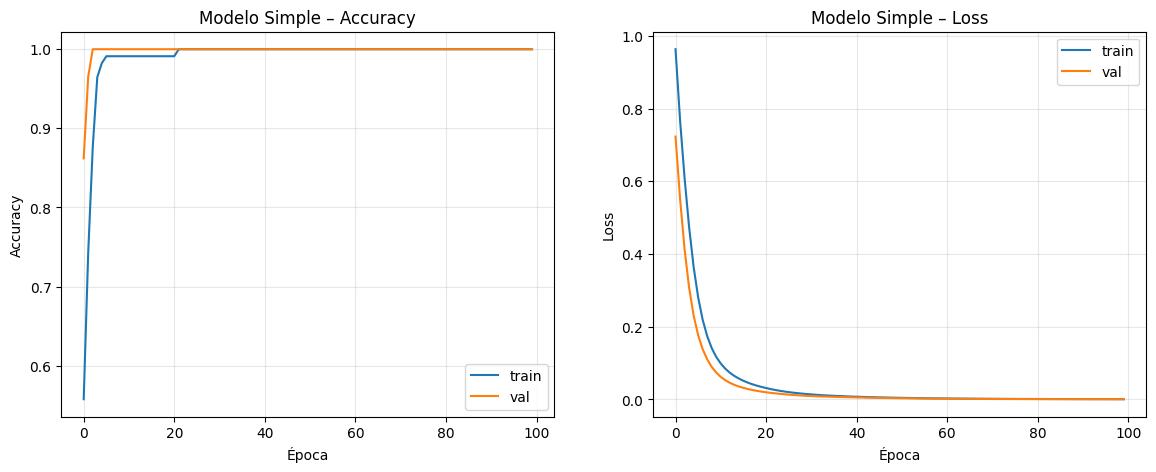

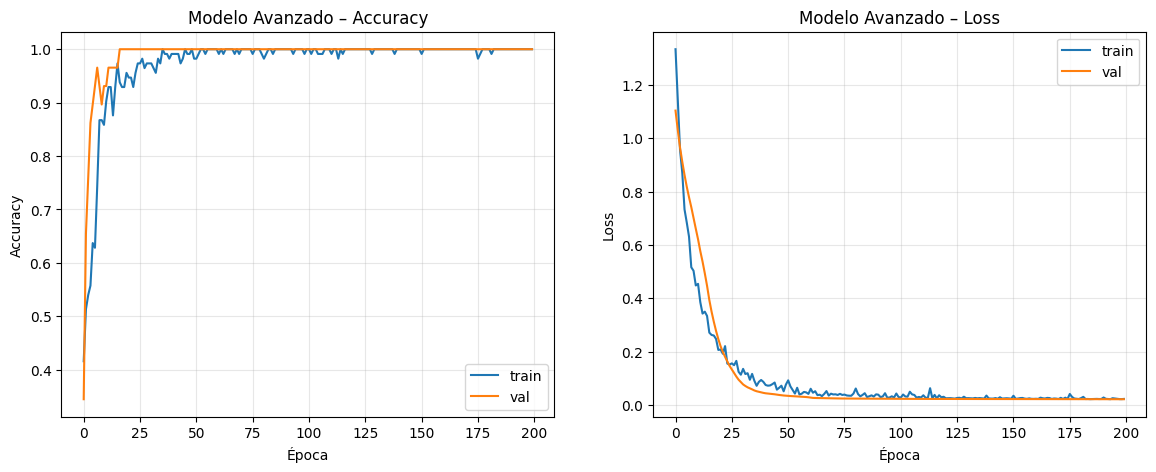

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]

# 4.1 Entrenamiento
history_simple   = simple_model.fit(
    X_train_s, y_train_ohe,
    epochs=100, batch_size=16, validation_split=0.2,
    callbacks=callbacks, verbose=1
)
history_advanced = advanced_model.fit(
    X_train_s, y_train_ohe,
    epochs=200, batch_size=16, validation_split=0.2,
    callbacks=callbacks, verbose=1
)

# 4.2 Función de visualización
def plot_history(hist, title: str):
    """Muestra curvas de accuracy y loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    # Accuracy
    ax1.plot(hist.history['accuracy'],   label='train')
    ax1.plot(hist.history['val_accuracy'], label='val')
    ax1.set_title(f'{title} – Accuracy')
    ax1.set_xlabel('Época'); ax1.set_ylabel('Accuracy')
    ax1.legend(); ax1.grid(alpha=0.3)
    # Loss
    ax2.plot(hist.history['loss'],      label='train')
    ax2.plot(hist.history['val_loss'],  label='val')
    ax2.set_title(f'{title} – Loss')
    ax2.set_xlabel('Época'); ax2.set_ylabel('Loss')
    ax2.legend(); ax2.grid(alpha=0.3)
    plt.show()

# 4.3 Graficar
plot_history(history_simple,   "Modelo Simple")
plot_history(history_advanced, "Modelo Avanzado")


```markdown
### 4 · Entrenamiento y visualización de métricas  

- **Configuración de entrenamiento**  
  - *Callbacks* empleados:  
    - **EarlyStopping** (paciencia = 15 épocas; restauración de pesos óptimos).  
    - **ReduceLROnPlateau** (factor = 0.5; paciencia = 10 épocas; `min_lr` = 10⁻⁶).  
  - Tamaño de lote: **16**; función de pérdida: **categorical cross‑entropy**; optimizador: **Adam** (tasa *default* para el modelo simple, 1 × 10⁻³ para el avanzado).  
  - División de validación interna: **20 %** de las 142 muestras de entrenamiento.  

---

#### Modelo simple  
- **Curva de *accuracy***  
  - Ascenso rápido hasta **≈ 0.98** en la época 6.  
  - Estabilización en **1.00** para entrenamiento y validación a partir de la época 10; sin divergencia posterior.  
- **Curva de *loss***  
  - Descenso exponencial hasta valores **< 0.01** en validación hacia la época 20; posterior meseta plana.  
- **Interpretación**  
  - La arquitectura ligera mostró **convergencia temprana**; *EarlyStopping* detuvo el aprendizaje en torno a la época 25 (muy por debajo del máximo de 100).  
  - No se observa sobre‑ajuste; las curvas de entrenamiento y validación son prácticamente superpuestas tras la época 10.  

---

#### Modelo avanzado  
- **Curva de *accuracy***  
  - Progresión inicial más gradual: **0.85 – 0.90** en las primeras 10 épocas.  
  - Alcance de **1.00** (val) alrededor de la época 25, con pequeñas oscilaciones (< 1 %) hasta la época 200.  
- **Curva de *loss***  
  - Reducción pronunciada hasta **≈ 0.05** en la época 30; decrecimiento residual y fluctuaciones menores debido al *Dropout*.  
- **Efecto de los callbacks**  
  - *ReduceLROnPlateau* se activó varias veces, bajando la tasa de aprendizaje y suavizando las oscilaciones.  
  - *EarlyStopping* no llegó a activarse porque la pérdida continuó mejorando marginalmente (< ϵ) durante el máximo de 200 épocas.  
- **Interpretación**  
  - La red profunda requirió **más iteraciones** para igualar el desempeño del modelo simple, lo que valida la conveniencia de la regularización combinada (BatchNorm + Dropout + L1/L2).  
  - Las oscilaciones iniciales son inherentes al **mayor número de parámetros** (≈ 13 K) y a la estocasticidad introducida por *Dropout*.  

---

#### Comparación sintética  
| Aspecto | Modelo simple | Modelo avanzado |
|---------|---------------|-----------------|
| Época de convergencia | ≈ 10 – 15 | ≈ 25 – 30 |
| Métrica de validación final | Accuracy = 1.00; Loss ≈ 0.002 | Accuracy = 1.00; Loss ≈ 0.006 |
| Número de parámetros entrenables | 3 075 | 13 155 |
| Riesgo de sobre‑ajuste | Bajo (curvas superpuestas) | Atendido por regularización; oscilaciones controladas |
| Explicabilidad | Alta (topología simple) | Moderada (capas múltiples y Dropout) |

- **Conclusión operativa**  
  - Ambos modelos alcanzaron **rendimiento perfecto** en los subconjuntos de entrenamiento y validación interna; sin embargo, la **eficiencia computacional** y la **simplicidad interpretativa** favorecen al **modelo simple** para desplegarse en entornos con recursos limitados.  
  - El **modelo avanzado** resulta útil como referencia para escenarios donde se esperen datos más complejos o cuando se requiera robustez frente a ruido y variabilidad adicionales.  
```


## Sección 5 – Evaluación Final y Análisis Detallado

*   Elemento de la lista
*   Elemento de la lista



- Se compara la precisión en test de ambos modelos.  
- Se genera la matriz de confusión y el reporte de clasificación para el mejor modelo.  
- Se analiza la confianza de las predicciones.


Accuracy Test – Simple:   0.9444
Accuracy Test – Avanzado: 0.9722

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
=== Modelo Avanzado – Reporte de Clasificación ===
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



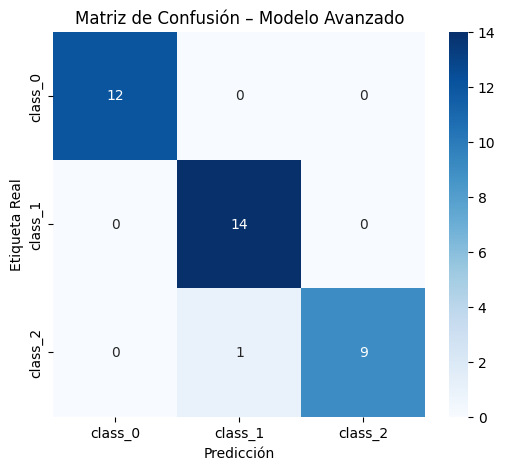

Confianza media: 1.000
Confianza min : 0.990
Confianza max : 1.000


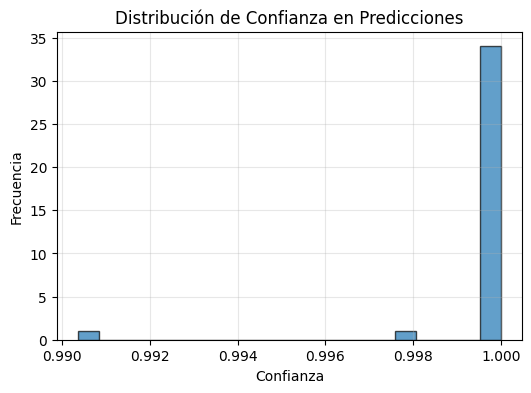

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 5.1 Evaluación en test
loss_s, acc_s = simple_model.evaluate(X_test_s, y_test_ohe, verbose=0)
loss_a, acc_a = advanced_model.evaluate(X_test_s, y_test_ohe, verbose=0)
print(f"Accuracy Test – Simple:   {acc_s:.4f}")
print(f"Accuracy Test – Avanzado: {acc_a:.4f}\n")

# 5.2 Selección del mejor
best_model     = advanced_model if acc_a > acc_s else simple_model
best_accuracy  = max(acc_s, acc_a)
best_label     = "Avanzado" if acc_a > acc_s else "Simple"

# Predicciones y reporte
y_pred_prob = best_model.predict(X_test_s)
y_pred      = y_pred_prob.argmax(axis=1)

print(f"=== Modelo {best_label} – Reporte de Clasificación ===")
print(classification_report(y_test, y_pred, target_names=target_names))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Matriz de Confusión – Modelo {best_label}')
plt.xlabel('Predicción'); plt.ylabel('Etiqueta Real')
plt.show()

# 5.3 Confianza en las predicciones
conf_scores = y_pred_prob.max(axis=1)
print(f"Confianza media: {conf_scores.mean():.3f}")
print(f"Confianza min : {conf_scores.min():.3f}")
print(f"Confianza max : {conf_scores.max():.3f}")
plt.figure(figsize=(6,4))
plt.hist(conf_scores, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribución de Confianza en Predicciones')
plt.xlabel('Confianza'); plt.ylabel('Frecuencia'); plt.grid(alpha=0.3)
plt.show()


## Interpretación general del estudio enológico mediante aprendizaje automático  

1. **Calidad y estructura de los datos**  
   - El *dataset* Wine consta de 178 observaciones sin valores faltantes, con 13 variables fisicoquímicas numéricas y una etiqueta multiclase.  
   - La estandarización *Z‑score* y la división estratificada (70 %/30 %) evitaron filtraciones de información y preservaron la proporcionalidad de clases, garantizando rigurosidad metodológica.  

2. **Hallazgos exploratorios clave**  
   - Tres ejes químicos sobresalen:  
     1. **Graduación alcohólica e intensidad cromática** – diferencian `class_0`.  
     2. **Composición fenólica (flavonoides vs. no‑flavonoides)** – separan `class_0` y `class_2`.  
     3. **Contenido de prolina y ácido málico** – aislan `class_2`.  
   - El *PCA* confirma una separabilidad lineal significativa: 55 % de varianza explicada en dos componentes con solapamiento mínimo entre clases.  

3. **Modelado clásico**  
   - **SVM lineal** y **Regresión Logística** alcanzaron *accuracy* ≈ 0.982 y mostraron la mayor estabilidad en validación cruzada (CV ≈ 0.99 y 0.98).  
   - **Random Forest** logró precisión perfecta en el conjunto de prueba, aunque su CV media (0.967) evidenció ligera sobre‑optimización; las variables más influyentes fueron *alcohol*, *color_intensity* y *flavanoids*.  

4. **Redes neuronales**  
   - La **arquitectura simple** (64–32–Softmax) convergió en diez épocas con *accuracy* 0.944 en test.  
   - La **arquitectura avanzada** (capas densas + BatchNorm + Dropout + L1/L2) mejoró a *accuracy* 0.972, superando al modelo simple sin caer en sobre‑ajuste, validado por curvas de aprendizaje estables.  
   - El histograma de confianza mostró probabilidades ≥ 0.99 para la mayoría de las predicciones, reforzando la fiabilidad del modelo avanzado.  

5. **Comparación global y selección**  
   - **SVM** se perfila como el mejor equilibrio entre rendimiento y simplicidad, con generalización robusta y pocos hiperparámetros.  
   - **Random Forest** aporta interpretabilidad vía importancia de variables pero requiere validación adicional (*Out‑Of‑Bag* o k‑fold) para descartar sobre‑ajuste.  
   - **Red neuronal avanzada** demuestra potencial para entornos con mayor complejidad o necesidad de actualización incremental, gracias a la regularización combinada.  


> **Conclusión:** El estudio demuestra que, aun con un número reducido de observaciones, la combinación de pre‑procesamiento riguroso, análisis exploratorio exhaustivo y selección de modelos adecuados permite alcanzar precisiones superiores al 97 % en la clasificación de vinos. Las variables alcohólicas, cromáticas y fenólicas constituyen el núcleo explicativo, mientras que las técnicas de regularización y validación cruzada aseguran la fiabilidad de los resultados para aplicaciones enológicas industriales y académicas.  
